# 20250402 - parse result of COMSOL parametric sweep
* Specifically emerging from simulation of photobleached species in a circular region in contact with bath from which recovery emerges.
* The COMSOL model file is `/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/2025_3D_nosurfbinding.mph`.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_style('ticks')

import numpy as np
import scipy

In [3]:
fname='/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250402_sweepKbleach_.csv'
chimney = pd.read_csv(fname)
chimney=chimney[['kbleach (1/s)', 'Time (s)', 'U (mol/m^3)']]
chimney

FileNotFoundError: [Errno 2] No such file or directory: '/Users/anaduarte/RPgroup/am_atp/data/COMSOL/photobleaching/20250324_3D_nosurfbinding/20250402_sweepKbleach_.csv'

In [ ]:
chimney.head()

In [9]:
kbleachList=chimney['kbleach (1/s)'].unique()

In [12]:
len(kbleachList)

13

In [ ]:
UvalsList=

In [20]:
sns.color_palette('mako', as_cmap=True)(0.5)

(0.20692679, 0.48201774, 0.63812656, 1.0)

In [21]:
chimney_subset.shape

(201, 3)

In [32]:
kbleach

100.0

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

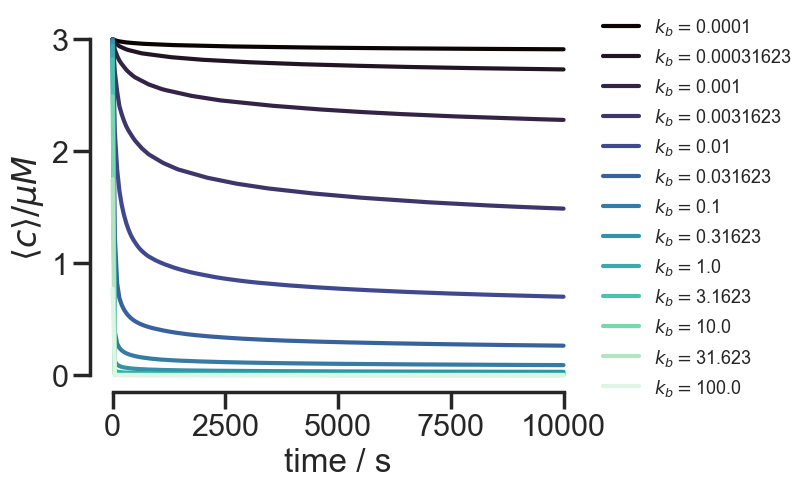

In [42]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.plot(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii],
            label=r'$k_b=$'+str(kbleach))

sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

In [77]:
chimney_subset['Time (s)'].values[-1]

10000.0

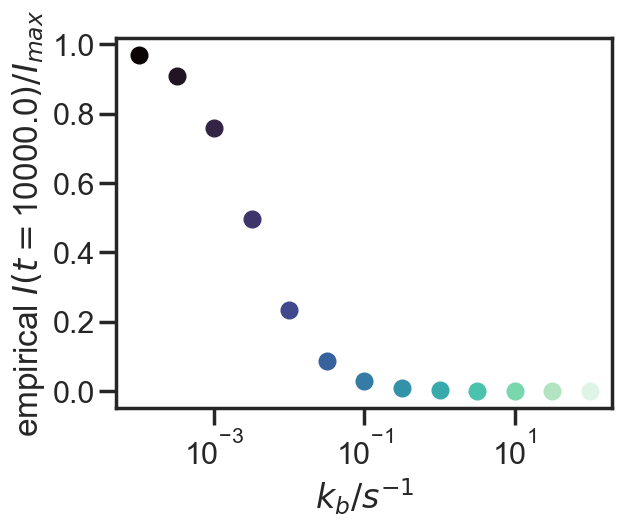

In [86]:
for ii in range(len(kbleachList)):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleachList[ii]]
    plt.plot(kbleachList[ii], chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].values.max(), 'o', color=colorList[ii])
plt.ylabel("empirical $I(t=$"+str(chimney_subset['Time (s)'].values[-1])+'$)/I_{max}$')
plt.xlabel('$k_b / s^{-1}$')
plt.xscale('log')

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

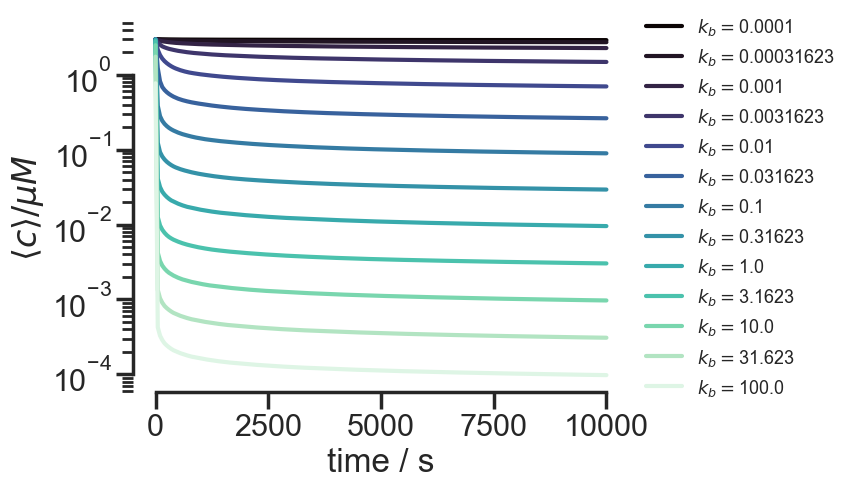

In [43]:

colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.plot(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii],
            label=r'$k_b=$'+str(kbleach))

    
plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

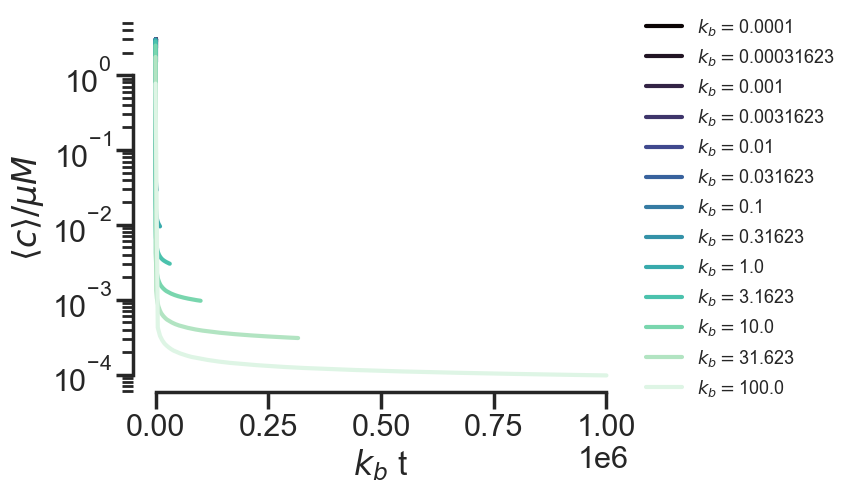

In [45]:
### Try simplest data collapse,
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.plot(chimney_subset['Time (s)']*kbleach, 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii],
            label=r'$k_b=$'+str(kbleach))

    
plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('$k_b$ t')
plt.ylabel(r'$\langle c \rangle / \mu M$')

# we be plottin

In [103]:
tol=1e-8
#--------------------------------------------------------------------#
def singExpConst_max1(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [ tau1, Iinf], where tau1 is the decay constant of the exponential and Iinf is the limit of the intensity as you go to infinity
    """
    tau1 = p0[0]
    Iinf = p0[1]

    return (1-Iinf)*np.exp(-times/tau1)+Iinf
    
def singExpConstFit_max1(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-singExpConst_max1(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

#--------------------------------------------------------------------#
def doubExp_max1(times, p0):
    """
    times: array of time points
    p0: list of initial parameter values guesses of the form [tau1, w2, tau2], where tau1(2) is the decay constant of the first(second) exponential and Iinf is the limit of the intensity as you go to infinity
    """
    tau1 = p0[0]
    Iinf = p0[1]
    tau2 = p0[2]

    return (1-Iinf)*np.exp(-times/tau1)+Iinf*np.exp(-times/tau2)
    
def doubExpFit_max1(times, vals, initialGuess):
    residual=lambda p0: np.sum((vals-doubExp_max1(times, p0))**2)
    result = scipy.optimize.minimize(residual, initialGuess, tol=tol)
    return result

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

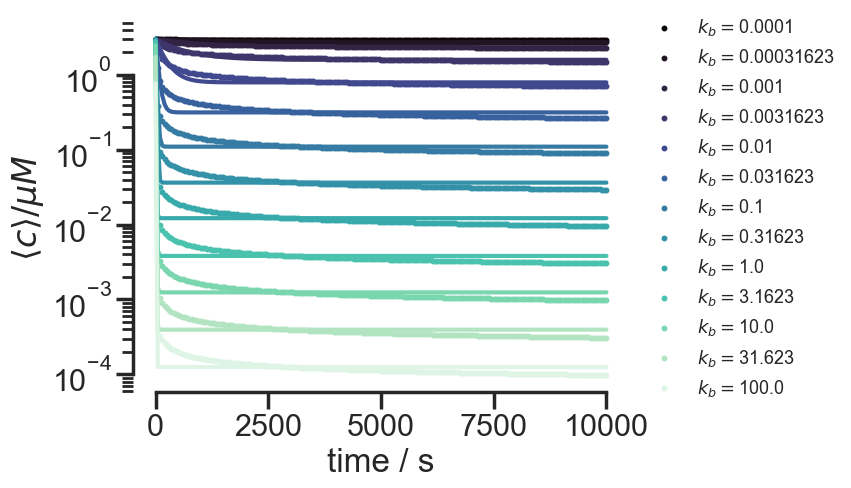

In [87]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.scatter(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
            label=r'$k_b=$'+str(kbleach))

    temp_fit = singExpConstFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max()))
    
    plt.plot(chimney_subset['Time (s)'], 
             singExpConst_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

In [97]:
chimney_subset['Time (s)'].head(81)

2412       0.0
2413      50.0
2414     100.0
2415     150.0
2416     200.0
         ...  
2488    3800.0
2489    3850.0
2490    3900.0
2491    3950.0
2492    4000.0
Name: Time (s), Length: 81, dtype: float64

Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

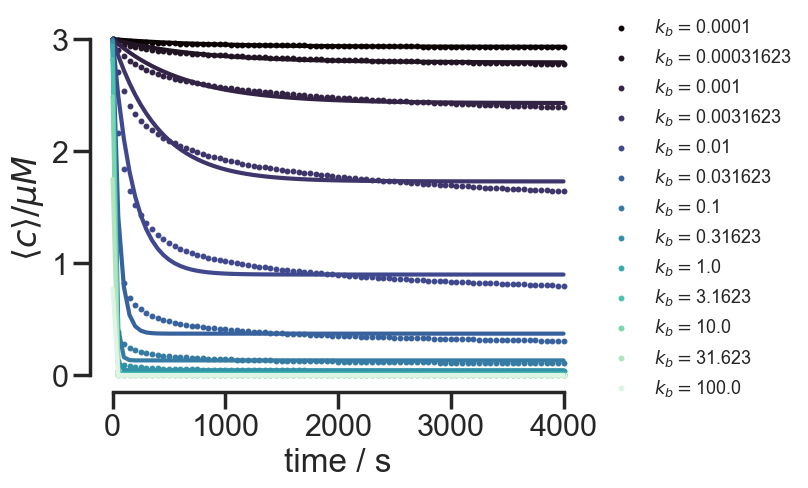

In [98]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.scatter(chimney_subset['Time (s)'][:81], 
             10**3*chimney_subset['U (mol/m^3)'][:81], color=colorList[ii], s=5,
            label=r'$k_b=$'+str(kbleach))

    temp_fit = singExpConstFit_max1(chimney_subset['Time (s)'][:81], 
                                    chimney_subset['U (mol/m^3)'][:81]/chimney_subset['U (mol/m^3)'][:81].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'][:81].values[-1]/chimney_subset['U (mol/m^3)'][:81].max()))
    
    plt.plot(chimney_subset['Time (s)'][:81], 
             singExpConst_max1(chimney_subset['Time (s)'][:81],temp_fit.x)*chimney_subset['U (mol/m^3)'][:81].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')

      fun: 0.0005630534676843565
 hess_inv: array([[ 5.96456362e+08, -1.60717609e+03],
       [-1.60717609e+03,  7.60819923e-03]])
      jac: array([ 3.78349796e-10, -9.04172339e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 330
      nit: 39
     njev: 106
   status: 2
  success: False
        x: array([1.52027328e+03, 9.71825524e-01])
      fun: 0.005112452440529113
 hess_inv: array([[ 1.98195692e+02, -1.89972886e-03],
       [-1.89972886e-03,  2.73518606e-03]])
      jac: array([-5.82076609e-11,  5.76494494e-06])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 257
      nit: 22
     njev: 82
   status: 2
  success: False
        x: array([1.41563426e+03, 9.16146221e-01])
      fun: 0.03873255696044571
 hess_inv: array([[1.25305694e+02, 3.47938167e-02],
       [3.47938167e-02, 2.99639402e-03]])
      jac: array([4.65661287e-10, 2.38604844e-06])
  message: 'Desired error not necessarily achieved due to 

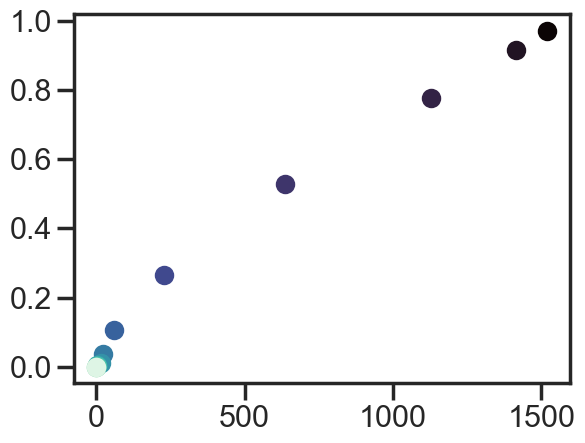

In [88]:
for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    temp_fit = singExpConstFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, 0.75))
    print(temp_fit)
    plt.scatter(temp_fit.x[0], temp_fit.x[1], color = colorList[ii])

      fun: 0.012783718884894992
 hess_inv: array([[4.10081932e+10, 1.53833534e+07, 7.31881289e+09],
       [1.53833534e+07, 5.83865109e+03, 2.74549736e+06],
       [7.31881289e+09, 2.74549736e+06, 1.30620293e+09]])
      jac: array([ 2.18860805e-08, -3.26900044e-05, -1.01281330e-08])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 648
      nit: 82
     njev: 159
   status: 2
  success: False
        x: array([1.05928275e+05, 5.95992283e+00, 1.17120504e+05])
      fun: 0.0008229596765481613
 hess_inv: array([[4.61950221e+03, 1.72321467e-01, 8.39299514e+03],
       [1.72321467e-01, 1.97653999e-03, 3.11679330e-01],
       [8.39299514e+03, 3.11679330e-01, 1.52626452e+04]])
      jac: array([1.45519152e-10, 2.57228385e-06, 2.40106601e-10])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 843
      nit: 78
     njev: 206
   status: 2
  success: False
        x: array([6.13663932e+02, 9.40863205e-01, 2.73125094e+05])


Text(0, 0.5, '$\\langle c \\rangle / \\mu M$')

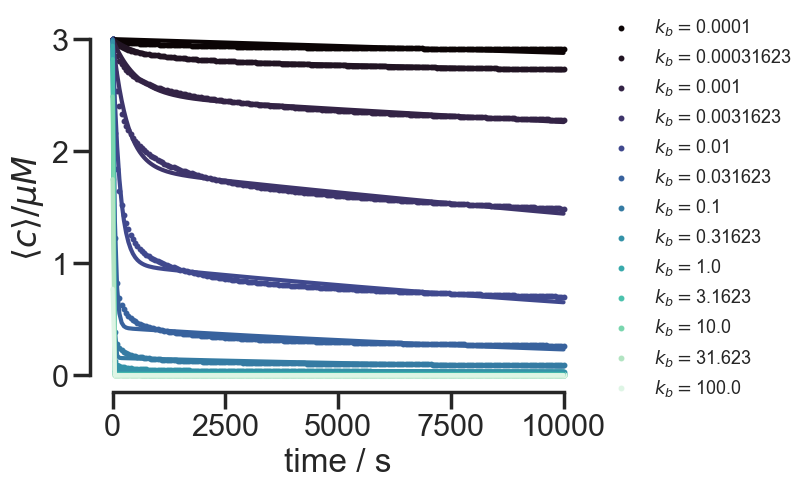

In [142]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.scatter(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
            label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    print(temp_fit)
    
    plt.plot(chimney_subset['Time (s)'], 
             doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')



In [1]:
#### start here

colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    plt.scatter(chimney_subset['Time (s)'], 
             10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
            label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    print(temp_fit)
    
    plt.plot(chimney_subset['Time (s)'], 
             doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
sns.despine(trim=True)

plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel('time / s')
plt.ylabel(r'$\langle c \rangle / \mu M$')



The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


NameError: name 'np' is not defined

(-100.0, 2500.0)

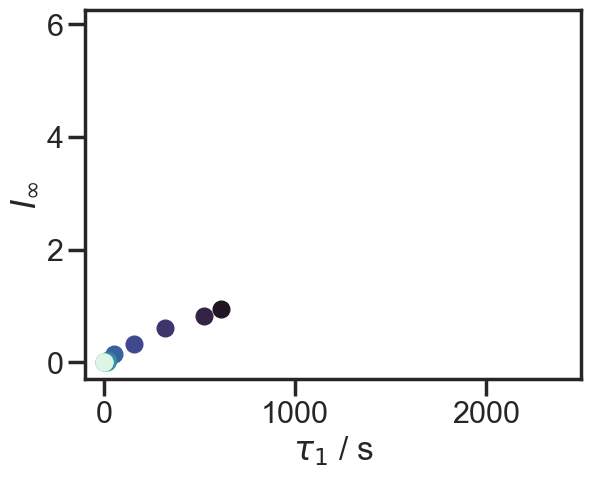

In [123]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    #print(temp_fit)
    
    # plt.plot(chimney_subset['Time (s)'], 
    #          doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
    plt.plot(temp_fit.x[0], temp_fit.x[1], 'o', color=colorList[ii])
    
#sns.despine(trim=True)

#plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.xlabel(r'$\tau_1$ / s')
plt.ylabel(r'$I_\infty$')

plt.xlim([-100, 2500])

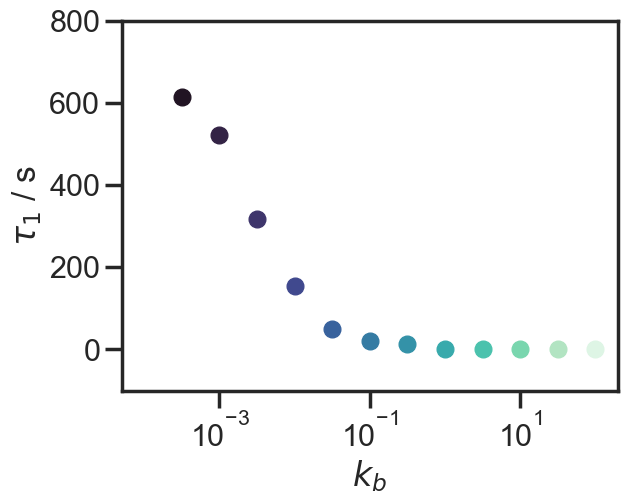

In [134]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    #print(temp_fit)
    
    # plt.plot(chimney_subset['Time (s)'], 
    #          doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
    plt.plot(kbleach, temp_fit.x[0], 'o', color=colorList[ii])
    
#sns.despine(trim=True)

#plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.ylabel(r'$\tau_1$ / s')
plt.xlabel(r'$k_b$')

plt.ylim(-100, 800)

plt.xscale('log')

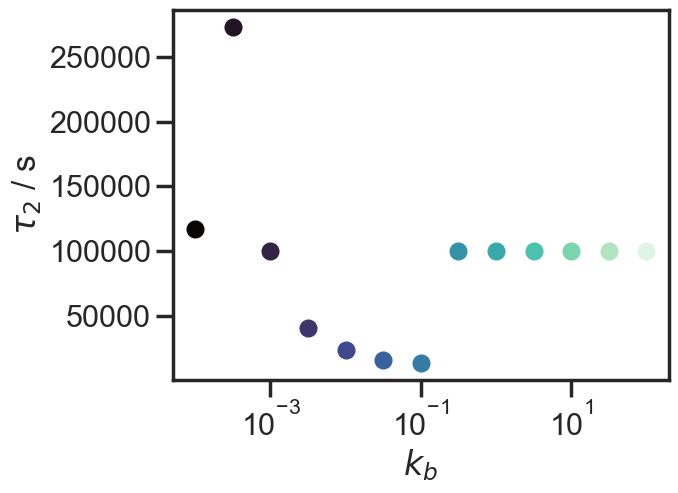

In [139]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    #print(temp_fit)
    
    # plt.plot(chimney_subset['Time (s)'], 
    #          doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
    plt.plot(kbleach, temp_fit.x[-1], 'o', color=colorList[ii])
    
#sns.despine(trim=True)

#plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.ylabel(r'$\tau_2$ / s')
plt.xlabel(r'$k_b$')

plt.xscale('log')

# plt.ylim(-100, 800)

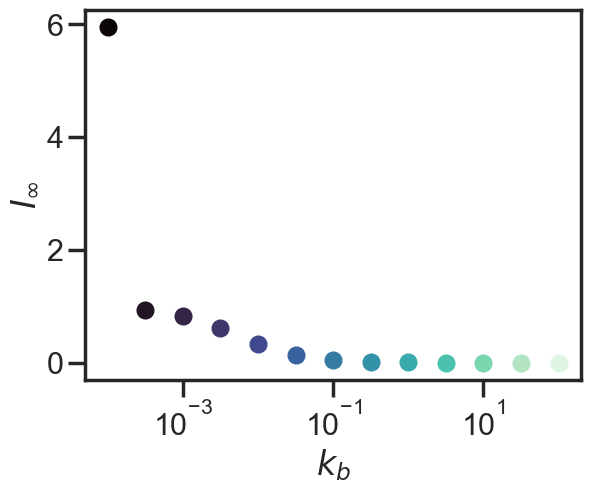

In [137]:
colorList=[sns.color_palette('mako', as_cmap=True)(x) for x in np.linspace(0,1,len(kbleachList))]

for ii, kbleach in enumerate(kbleachList):
    chimney_subset = chimney[chimney['kbleach (1/s)']==kbleach]
    # plt.scatter(chimney_subset['Time (s)'], 
    #          10**3*chimney_subset['U (mol/m^3)'], color=colorList[ii], s=5,
    #         label=r'$k_b=$'+str(kbleach))

    temp_fit = doubExpFit_max1(chimney_subset['Time (s)'], 
                                    chimney_subset['U (mol/m^3)']/chimney_subset['U (mol/m^3)'].max(), 
                                    (1/kbleach, chimney_subset['U (mol/m^3)'].values[-1]/chimney_subset['U (mol/m^3)'].max(), 100000))
    #print(temp_fit)
    
    # plt.plot(chimney_subset['Time (s)'], 
    #          doubExp_max1(chimney_subset['Time (s)'],temp_fit.x)*chimney_subset['U (mol/m^3)'].max()*10**3, color = colorList[ii])
    
# plt.yscale('log')
    
    plt.plot(kbleach, temp_fit.x[1], 'o', color=colorList[ii])
    
#sns.despine(trim=True)

#plt.legend(frameon=False, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=13, borderaxespad=0)
plt.ylabel(r'$I_\infty$')
plt.xlabel(r'$k_b$')

plt.xscale('log')

# plt.ylim(-100, 800)